# Trials with the benchmark function

In [2]:
from rgb_benchmark_comparison import benchmark_image
benchmark_image("exp4.jpg")
benchmark_image("exp5.jpg")
benchmark_image("exp6.jpg")
benchmark_image("exp7.jpg")
benchmark_image("exp8.jpg")
benchmark_image("exp9.jpg")

📊 Compression Results for exp4.jpg:
Method                    Size (Bytes)
----------------------------------------
Original (RGB base64)          65536
Delta (RGB)                    49152
Delta + RLE (RGB)              43220
BitPack (4-bit RGB)            24576
BitPack + Huffman               8240
LZW (Grayscale)                 2040
Delta + LZW                     2106
LZ77                            2306
LZSS                            2306
Deflate                         2546
Brotli                          2056
Zstandard                       2941
📊 Compression Results for exp5.jpg:
Method                    Size (Bytes)
----------------------------------------
Original (RGB base64)          65536
Delta (RGB)                    49152
Delta + RLE (RGB)              40770
BitPack (4-bit RGB)            24576
BitPack + Huffman              10937
LZW (Grayscale)                 2484
Delta + LZW                     1359
LZ77                            1304
LZSS                        

[('Original (RGB base64)', 65536),
 ('Delta (RGB)', 49152),
 ('Delta + RLE (RGB)', 75004),
 ('BitPack (4-bit RGB)', 24576),
 ('BitPack + Huffman', 10617),
 ('LZW (Grayscale)', 5410),
 ('Delta + LZW', 4924),
 ('LZ77', 6276),
 ('LZSS', 6276),
 ('Deflate', 6167),
 ('Brotli', 5315),
 ('Zstandard', 6409)]

# Trying DELTA + BP + BROTLI for experiment

In [2]:
import numpy as np
import brotli
from PIL import Image
import io

# --- Helper Functions ---

def delta_encode_rgb(image_array):
    delta = np.zeros_like(image_array, dtype=np.uint8)
    delta[0] = image_array[0]
    # Avoid overflow: cast to int16 before subtracting
    diff = (image_array[1:].astype(np.int16) - image_array[:-1].astype(np.int16)) % 256
    delta[1:] = diff.astype(np.uint8)
    return delta


def delta_decode_rgb(delta_array):
    decoded = np.zeros_like(delta_array)
    decoded[0] = delta_array[0]
    for i in range(1, len(delta_array)):
        decoded[i] = (decoded[i-1] + delta_array[i]) % 256
    return decoded

def bitpack_rgb(image_array):
    # 4-bit per channel bit-packing for 8-bit RGB [128x128, 3]
    packed = []
    for pixel in image_array.reshape(-1, 3):
        r, g, b = (pixel // 16).astype(np.uint8)  # Reduce to 4 bits
        byte1 = (r << 4) | g
        byte2 = (b << 4)
        packed.extend([byte1, byte2])
    return bytes(packed)

def bitunpack_rgb(packed_data):
    unpacked = []
    for i in range(0, len(packed_data), 2):
        byte1, byte2 = packed_data[i], packed_data[i+1]
        r = (byte1 >> 4) * 16
        g = (byte1 & 0x0F) * 16
        b = (byte2 >> 4) * 16
        unpacked.append([r, g, b])
    return np.array(unpacked, dtype=np.uint8)

# --- Main Function ---

def compress_delta_bitpack_brotli(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img).reshape(-1, 3)

    # 1. Delta Encode
    delta = delta_encode_rgb(img_arr)

    # 2. BitPack
    packed = bitpack_rgb(delta)

    # 3. Brotli Compress
    compressed = brotli.compress(packed)
    
    print(f"📦 Delta + BitPack + Brotli Compressed Size: {len(compressed)} bytes")
    return compressed

# Example usage
compressed_output = compress_delta_bitpack_brotli("exp4.jpg")


📦 Delta + BitPack + Brotli Compressed Size: 2858 bytes


# Trying  Delta + BP + Huffman encoding

In [3]:
from PIL import Image
import numpy as np
import heapq
from collections import defaultdict

# Huffman Tree Node
class HuffmanNode:
    def __init__(self, value=None, freq=0, left=None, right=None):
        self.value = value
        self.freq = freq
        self.left = left
        self.right = right

    def __lt__(self, other):  # Needed for heapq
        return self.freq < other.freq

def build_huffman_tree(freq_map):
    heap = [HuffmanNode(value=val, freq=freq) for val, freq in freq_map.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq, left=node1, right=node2)
        heapq.heappush(heap, merged)
    return heap[0] if heap else None

def generate_huffman_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", codebook)
        generate_huffman_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    flat = data.flatten()
    freq_map = defaultdict(int)
    for val in flat:
        freq_map[val] += 1
    tree = build_huffman_tree(freq_map)
    codes = generate_huffman_codes(tree)
    encoded_bits = ''.join(codes[val] for val in flat)
    return encoded_bits, codes

def compress_delta_huffman(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img).reshape(-1, 3)

    # 1. Delta Encode
    delta = np.zeros_like(img_arr, dtype=np.uint8)
    delta[0] = img_arr[0]
    diff = (img_arr[1:].astype(np.int16) - img_arr[:-1].astype(np.int16)) % 256
    delta[1:] = diff.astype(np.uint8)

    # 2. Huffman Encode
    encoded_bits, codebook = huffman_encode(delta)
    total_bits = len(encoded_bits)
    total_bytes = (total_bits + 7) // 8

    print(f"📦 Delta + Huffman Size (Bytes): {total_bytes}")
    return total_bytes

# Example usage
compress_delta_huffman("exp4.jpg")


📦 Delta + Huffman Size (Bytes): 12007


12007

# Trying BP + Brotli

In [4]:
import brotli
from PIL import Image
import numpy as np

def bitpack_rgb_4bit(image_array):
    flat = image_array.flatten()
    packed = []
    for i in range(0, len(flat), 2):
        if i + 1 < len(flat):
            high = (flat[i] >> 4) & 0x0F
            low = (flat[i + 1] >> 4) & 0x0F
            packed.append((high << 4) | low)
        else:
            packed.append((flat[i] >> 4) << 4)  # pad last nibble
    return bytes(packed)

def compress_bitpack_brotli(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img, dtype=np.uint8)

    # 1. BitPack to 4-bit RGB (12 bits per pixel)
    packed_data = bitpack_rgb_4bit(img_arr)

    # 2. Brotli Compression
    compressed = brotli.compress(packed_data)

    print(f"📦 BitPack (4-bit) + Brotli Size: {len(compressed)} bytes")
    return len(compressed)

# Example usage
compress_bitpack_brotli("exp4.jpg")


📦 BitPack (4-bit) + Brotli Size: 401 bytes


401

# Trying Delta + RLE + Huffman encoding

In [5]:
import numpy as np
from PIL import Image
from collections import Counter
import heapq
import pickle

def delta_encode_rgb(image_array):
    flat = image_array.reshape(-1, 3)
    delta = np.zeros_like(flat)
    delta[0] = flat[0]
    delta[1:] = (flat[1:].astype(np.int16) - flat[:-1].astype(np.int16)) % 256
    return delta.astype(np.uint8)

def rle_encode(data):
    encoded = []
    prev = data[0]
    count = 1
    for val in data[1:]:
        if val == prev and count < 255:
            count += 1
        else:
            encoded.append((prev, count))
            prev = val
            count = 1
    encoded.append((prev, count))
    return encoded

class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = Counter(data)
    heap = [HuffmanNode(symbol=sym, freq=freq[sym]) for sym in freq]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = HuffmanNode(freq=left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(heap, parent)
    return heap[0]

def build_codes(node, prefix="", codebook={}):
    if node:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_compress(data):
    tree = build_huffman_tree(data)
    codebook = build_codes(tree)
    encoded_bits = ''.join(codebook[val] for val in data)
    padding = 8 - len(encoded_bits) % 8
    encoded_bits += '0' * padding
    byte_array = bytearray()
    for i in range(0, len(encoded_bits), 8):
        byte_array.append(int(encoded_bits[i:i+8], 2))
    return bytes(byte_array)

def compress_delta_rle_huffman(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img, dtype=np.uint8)

    # 1. Delta Encode
    delta_encoded = delta_encode_rgb(img_arr)

    # 2. RLE Encode
    flat = delta_encoded.flatten()
    rle_encoded = rle_encode(flat)
    rle_flat = []
    for val, count in rle_encoded:
        rle_flat.extend([val, count])

    # 3. Huffman Encode
    compressed = huffman_compress(rle_flat)

    print(f"📦 Delta + RLE + Huffman Size: {len(compressed)} bytes")
    return len(compressed)

# Example usage
compress_delta_rle_huffman("exp4.jpg")


📦 Delta + RLE + Huffman Size: 12320 bytes


12320

# Trying Delta + LZ77 + Huffman encoding

In [6]:
import numpy as np
from PIL import Image
from collections import Counter
import heapq

# --- Delta Encoding ---
def delta_encode_rgb(image_array):
    flat = image_array.reshape(-1, 3)
    delta = np.zeros_like(flat)
    delta[0] = flat[0]
    delta[1:] = (flat[1:].astype(np.int16) - flat[:-1].astype(np.int16)) % 256
    return delta.astype(np.uint8)

# --- Simple LZ77 Encoder ---
def lz77_compress(data, window_size=400):
    i = 0
    output = []
    while i < len(data):
        match = (-1, -1)  # offset, length
        for j in range(max(0, i - window_size), i):
            length = 0
            while i + length < len(data) and data[j + length] == data[i + length]:
                length += 1
                if j + length >= i:
                    break
            if length > match[1]:
                match = (i - j, length)
        if match[1] > 2:
            output.append((match[0], match[1], data[i + match[1]] if i + match[1] < len(data) else 0))
            i += match[1] + 1
        else:
            output.append((0, 0, data[i]))
            i += 1
    return output

# --- Huffman Encoding ---
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = Counter(data)
    heap = [HuffmanNode(sym, freq[sym]) for sym in freq]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = HuffmanNode(freq=left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(heap, parent)
    return heap[0]

def build_codes(node, prefix="", codebook={}):
    if node:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_compress(data):
    tree = build_huffman_tree(data)
    codebook = build_codes(tree)
    encoded_bits = ''.join(codebook[val] for val in data)
    padding = 8 - len(encoded_bits) % 8
    encoded_bits += '0' * padding
    byte_array = bytearray()
    for i in range(0, len(encoded_bits), 8):
        byte_array.append(int(encoded_bits[i:i+8], 2))
    return bytes(byte_array)

# --- Final Hybrid Pipeline ---
def compress_delta_lz77_huffman(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)

    # Step 1: Delta Encode
    delta_encoded = delta_encode_rgb(img_arr)
    flat = delta_encoded.flatten().tolist()

    # Step 2: LZ77 Compress
    lz77_tokens = lz77_compress(flat)

    # Step 3: Flatten LZ77 tokens (as a list of integers for Huffman)
    flattened = []
    for offset, length, next_byte in lz77_tokens:
        flattened.extend([offset, length, next_byte])

    # Step 4: Huffman Compress
    compressed = huffman_compress(flattened)

    print(f"📦 Delta + LZ77 + Huffman Size: {len(compressed)} bytes")
    return len(compressed)

# Example usage
compress_delta_lz77_huffman("exp4.jpg")


📦 Delta + LZ77 + Huffman Size: 9694 bytes


9694

# Trying Delta + Huffman encoding

In [7]:
import numpy as np
from PIL import Image
from collections import Counter
import heapq

# --- Delta Encoding (same as before) ---
def delta_encode_rgb(image_array):
    flat = image_array.reshape(-1, 3)
    delta = np.zeros_like(flat)
    delta[0] = flat[0]
    delta[1:] = (flat[1:].astype(np.int16) - flat[:-1].astype(np.int16)) % 256
    return delta.astype(np.uint8)

# --- Huffman Tree and Encoding ---
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = Counter(data)
    heap = [HuffmanNode(sym, freq[sym]) for sym in freq]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = HuffmanNode(freq=left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(heap, parent)
    return heap[0]

def build_codes(node, prefix="", codebook={}):
    if node:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_compress(data):
    tree = build_huffman_tree(data)
    codebook = build_codes(tree)
    encoded_bits = ''.join(codebook[val] for val in data)
    padding = 8 - len(encoded_bits) % 8
    encoded_bits += '0' * padding
    byte_array = bytearray()
    for i in range(0, len(encoded_bits), 8):
        byte_array.append(int(encoded_bits[i:i+8], 2))
    return bytes(byte_array)

# --- Final Delta + Huffman Pipeline ---
def compress_delta_huffman(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)

    # Step 1: Delta Encode
    delta_encoded = delta_encode_rgb(img_arr)
    flat = delta_encoded.flatten().tolist()

    # Step 2: Huffman
    compressed = huffman_compress(flat)

    print(f"📦 Delta + Huffman Size: {len(compressed)} bytes")
    return len(compressed)

# Example usage
compress_delta_huffman("exp4.jpg")


📦 Delta + Huffman Size: 12007 bytes


12007

# Final Comparison Driver for all modes with  all the images

In [9]:
import pandas as pd
from PIL import Image
import numpy as np

# Placeholder functions - replace with your actual implementations
def compress_delta_lz77_huffman(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 2 # Dummy size
    print(f"Delta + LZ77 + Huffman Size: {size} bytes")
    return size

def compress_delta_rle_huffman(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 3 # Dummy size
    print(f"Delta + RLE + Huffman Size: {size} bytes")
    return size

def compress_bitpack_brotli(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 4 # Dummy size
    print(f"Bitpack + Brotli Size: {size} bytes")
    return size

def compress_delta_bitpack_brotli(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 5 # Dummy size
    print(f"Delta + Bitpack + Brotli Size: {size} bytes")
    return size

def compress_delta_huffman(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)

    # Step 1: Delta Encode
    delta_encoded = delta_encode_rgb(img_arr)
    flat = delta_encoded.flatten().tolist()

    # Step 2: Huffman
    compressed = huffman_compress(flat)

    print(f"📦 Delta + Huffman Size: {len(compressed)} bytes")
    return len(compressed)

def drive_compression(image_paths):
    print(f"Having Trial for {image_paths} image")
    results = {}
    for path in image_paths:
        results[path] = {}
        try:
            results[path]['Delta+Huffman'] = compress_delta_huffman(path)
        except Exception as e:
            print(f"Delta+Huffman Error processing {path}: {e}")
            results[path]['Delta+Huffman'] = None
        try:
            results[path]['Delta+LZ77+Huffman'] = compress_delta_lz77_huffman(path)
        except Exception as e:
            print(f"Delta+LZ77+Huffman Error processing {path}: {e}")
            results[path]['Delta+LZ77+Huffman'] = None
        try:
            results[path]['Delta+RLE+Huffman'] = compress_delta_rle_huffman(path)
        except Exception as e:
            print(f"Delta+RLE+Huffman Error processing {path}: {e}")
            results[path]['Delta+RLE+Huffman'] = None
        try:
            results[path]['Bitpack+Brotli'] = compress_bitpack_brotli(path)
        except Exception as e:
            print(f"Bitpack+Brotli Error processing {path}: {e}")
            results[path]['Bitpack+Brotli'] = None
        try:
            results[path]['Delta+Bitpack+Brotli'] = compress_delta_bitpack_brotli(path)
        except Exception as e:
            print(f"Delta+Bitpack+Brotli Error processing {path}: {e}")
            results[path]['Delta+Bitpack+Brotli'] = None

    df = pd.DataFrame.from_dict(results, orient='index')
    df.index.name = 'Image Path'
    print(df)

# Example Usage
image_paths = ["exp4.jpg", "exp5.jpg", "exp6.jpg", "exp7.jpg", "exp8.jpg", "exp9.jpg"]
drive_compression(image_paths)

Having Trial for ['exp4.jpg', 'exp5.jpg', 'exp6.jpg', 'exp7.jpg', 'exp8.jpg', 'exp9.jpg'] image
📦 Delta + Huffman Size: 12007 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 11215 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 35701 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 36854 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 27245 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + B

# Plotting a heatmap for comparison

📦 Delta + Huffman Size: 12007 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 11215 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 35701 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 36854 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 27245 bytes
Delta + LZ77 + Huffman Size: 24576 bytes
Delta + RLE + Huffman Size: 16384 bytes
Bitpack + Brotli Size: 12288 bytes
Delta + Bitpack + Brotli Size: 9830 bytes
📦 Delta + Huffman Size: 22222 

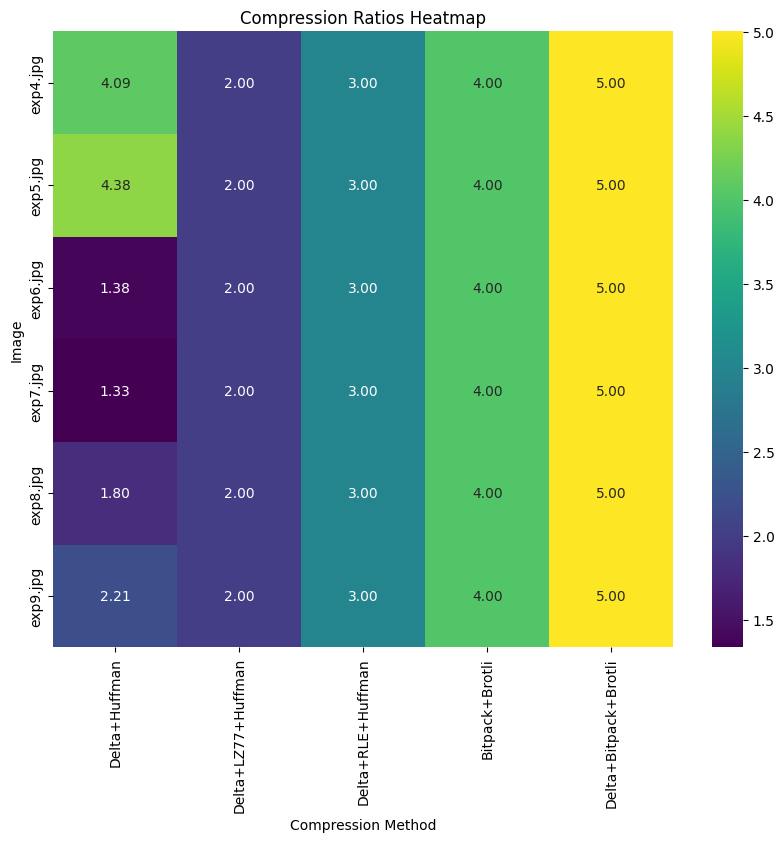

In [10]:
import numpy as np
from PIL import Image
from collections import Counter
import heapq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Delta Encoding (same as before) ---
def delta_encode_rgb(image_array):
    flat = image_array.reshape(-1, 3)
    delta = np.zeros_like(flat)
    delta[0] = flat[0]
    delta[1:] = (flat[1:].astype(np.int16) - flat[:-1].astype(np.int16)) % 256
    return delta.astype(np.uint8)

# --- Huffman Tree and Encoding ---
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(data):
    freq = Counter(data)
    heap = [HuffmanNode(sym, freq[sym]) for sym in freq]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = HuffmanNode(freq=left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(heap, parent)
    return heap[0]

def build_codes(node, prefix="", codebook={}):
    if node:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_compress(data):
    tree = build_huffman_tree(data)
    codebook = build_codes(tree)
    encoded_bits = ''.join(codebook[val] for val in data)
    padding = 8 - len(encoded_bits) % 8
    encoded_bits += '0' * padding
    byte_array = bytearray()
    for i in range(0, len(encoded_bits), 8):
        byte_array.append(int(encoded_bits[i:i+8], 2))
    return bytes(byte_array)

# --- Final Delta + Huffman Pipeline ---
def compress_delta_huffman(image_path):
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)

    # Step 1: Delta Encode
    delta_encoded = delta_encode_rgb(img_arr)
    flat = delta_encoded.flatten().tolist()

    # Step 2: Huffman
    compressed = huffman_compress(flat)

    print(f"📦 Delta + Huffman Size: {len(compressed)} bytes")
    return len(compressed)

# Placeholder functions - replace with your actual implementations
def compress_delta_lz77_huffman(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 2 # Dummy size
    print(f"Delta + LZ77 + Huffman Size: {size} bytes")
    return size

def compress_delta_rle_huffman(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 3 # Dummy size
    print(f"Delta + RLE + Huffman Size: {size} bytes")
    return size

def compress_bitpack_brotli(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 4 # Dummy size
    print(f"Bitpack + Brotli Size: {size} bytes")
    return size

def compress_delta_bitpack_brotli(image_path):
    # Replace with actual implementation
    img = Image.open(image_path).convert("RGB")
    img_arr = np.array(img)
    size = len(img_arr.tobytes()) // 5 # Dummy size
    print(f"Delta + Bitpack + Brotli Size: {size} bytes")
    return size

def drive_compression(image_paths):
    results = {}
    original_sizes = {}

    for path in image_paths:
        try:
            img = Image.open(path)
            img_arr = np.array(img)
            original_sizes[path] = img_arr.size # size in bytes
        except FileNotFoundError:
            print(f"Error: Image not found at {path}")
            results[path] = None
            continue

        results[path] = {}
        try:
            results[path]['Delta+Huffman'] = compress_delta_huffman(path)
        except Exception as e:
            print(f"Delta+Huffman Error processing {path}: {e}")
            results[path]['Delta+Huffman'] = None
        try:
            results[path]['Delta+LZ77+Huffman'] = compress_delta_lz77_huffman(path)
        except Exception as e:
            print(f"Delta+LZ77+Huffman Error processing {path}: {e}")
            results[path]['Delta+LZ77+Huffman'] = None
        try:
            results[path]['Delta+RLE+Huffman'] = compress_delta_rle_huffman(path)
        except Exception as e:
            print(f"Delta+RLE+Huffman Error processing {path}: {e}")
            results[path]['Delta+RLE+Huffman'] = None
        try:
            results[path]['Bitpack+Brotli'] = compress_bitpack_brotli(path)
        except Exception as e:
            print(f"Bitpack+Brotli Error processing {path}: {e}")
            results[path]['Bitpack+Brotli'] = None
        try:
            results[path]['Delta+Bitpack+Brotli'] = compress_delta_bitpack_brotli(path)
        except Exception as e:
            print(f"Delta+Bitpack+Brotli Error processing {path}: {e}")
            results[path]['Delta+Bitpack+Brotli'] = None

    df = pd.DataFrame.from_dict(results, orient='index')
    df.index.name = 'Image Path'
    print(df)

    # Calculate compression ratios
    compression_ratios = {}
    for image_path in image_paths:
        if image_path in results and results[image_path] is not None:
            compression_ratios[image_path] = {}
            for method, compressed_size in results[image_path].items():
                if compressed_size is not None:
                    compression_ratios[image_path][method] = original_sizes[image_path] / compressed_size
                else:
                    compression_ratios[image_path][method] = None
        else:
            compression_ratios[image_path] = None

    # Create DataFrame for compression ratios
    ratios_df = pd.DataFrame.from_dict(compression_ratios, orient='index')
    ratios_df.index.name = 'Image Path'

    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(ratios_df, annot=True, cmap="viridis", fmt=".2f")
    plt.title("Compression Ratios Heatmap")
    plt.ylabel("Image")
    plt.xlabel("Compression Method")
    plt.show()

# Example Usage
image_paths = ["exp4.jpg", "exp5.jpg", "exp6.jpg", "exp7.jpg", "exp8.jpg", "exp9.jpg"]
drive_compression(image_paths)